<a href="https://colab.research.google.com/github/Cferro2793/cbam/blob/main/RESNET_LAB_1g.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
import numpy as np
import tensorflow.keras as keras
from keras.models import Sequential
from keras.models import Model #faltaba
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense,   Activation, BatchNormalization, Add, Multiply, Input, Reshape, Conv2DTranspose
from keras.layers import AveragePooling2D, GlobalAveragePooling2D,AveragePooling1D, GlobalAveragePooling1D, Lambda, Concatenate
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import regularizers, optimizers
from keras.datasets import cifar10
from tensorflow.keras.regularizers import l2
import tensorflow as tf


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
#import keras.models 
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization, Add, Multiply, Input, Reshape
from keras.layers import AveragePooling2D, GlobalAveragePooling2D
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import regularizers, optimizers
from keras.datasets import cifar10
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import datetime
import cv2
from keras.preprocessing.image import img_to_array
from IPython.display import Image, display
import datetime


# **FUNTIONS FOR GRAD - CAM**

In [5]:
#Algortimo de GradCAM para visualizacion
#Author: fchollet
#Libro: Deep Learning with Python (2017)
#Description: How to obtain a class activation heatmap for an image classification model.

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [6]:
def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

# **FUNCTIONS FOR ATENTION MODELS**

CBAM

In [7]:
#CHANEL ATENTION
def ch_attention(input_t, ratio=8):
  inputs = input_t
  channel_axis=1 if K.image_data_format()=='channels_first' else -1
  filters = inputs.shape[channel_axis]

  #definir la MLP compartida
  MLP_Layer_S1 = Dense(filters//ratio, activation='relu', kernel_initializer='he_normal', use_bias = True, bias_initializer='zeros')
  MLP_Layer_S2 = Dense(filters, activation='relu', kernel_initializer='he_normal', use_bias = True, bias_initializer='zeros')

  #operando el average pooling
  avg_pool = GlobalAveragePooling2D()(inputs)
  avg_pool = Reshape((1,1,filters))(avg_pool)
  avg_pool = MLP_Layer_S1(avg_pool)
  avg_pool = MLP_Layer_S2(avg_pool)

  #operando el max pooling
  max_pool = MaxPooling2D(pool_size=(inputs.shape[-3],inputs.shape[-2]),strides=(1, 1))(inputs)
  max_pool = Reshape((1,1,filters))(max_pool)
  max_pool = MLP_Layer_S1(max_pool)
  max_pool = MLP_Layer_S2(max_pool)

  #sumando las dos operacione

  cbam_feat_ch = Add()([avg_pool, max_pool])

  cbam_feat_ch = Activation('sigmoid')(cbam_feat_ch)

  cbam_feat_ch = Multiply()([cbam_feat_ch, inputs])
  return cbam_feat_ch


In [8]:
#SPACIAL ATENTION
def sp_attention(input_t, kz =7):
  inputs = input_t
  avg_pool = Lambda(lambda x: K.max(x,axis=3, keepdims=True))(inputs)
  max_pool = Lambda(lambda x: K.mean(x,axis=3, keepdims=True))(inputs)
  concat = Concatenate(axis =3)([avg_pool, max_pool])
  cbam_feat_sp = Conv2D(filters=1, kernel_size=kz,strides=1, padding='same', activation='sigmoid',
  kernel_initializer='he_normal', use_bias = False)(concat)
  cbam_feat_sp = Multiply()([cbam_feat_sp,inputs])
  return(cbam_feat_sp)


In [9]:
#UNION OF FUNTION
def cbam_block(input_t):
  inputs=input_t
  cbam_feat_ch = ch_attention(inputs)
  cbam_feat = sp_attention(cbam_feat_ch)
  
  return cbam_feat


Squeeze - Excitation

In [10]:
def squeeze_excite_block(input_t, ratio=16):
  init = input_t
  channel_axis=1 if K.image_data_format()=="channel_first" else -1
  filters = init.shape[channel_axis]
  se_shape=(1,1,filters)
  se = GlobalAveragePooling2D()(init)
  se = Reshape(se_shape)(se)
  se = Dense(filters // ratio, activation='relu', 
             kernel_initializer='he_normal', use_bias=False)(se)
  se = Dense(filters, activation='sigmoid',
             kernel_initializer='he_normal',use_bias=False)(se)
  x = Multiply()([init, se])     
  return x      


# **FUNTION TO CREATE RESNET**

In [11]:
def initial_block_conv(Input, filters,kz=7,stride=1):
  x = Conv2D(filters,kernel_size=(kz,kz),strides=(stride,stride), padding='same', use_bias =False)(Input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [12]:
def conv_block(Input,filters,stride=1):
  #Bloque 1x1
  x = Conv2D(filters,kernel_size=(1,1),strides=(stride,stride), padding='same', kernel_initializer='he_normal', use_bias =False)(Input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #Bloque 3x3
  x = Conv2D(filters,kernel_size=(3,3),strides=(stride,stride), padding='same', kernel_initializer='he_normal', use_bias =False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #Bloque 1x1
  x = Conv2D(filters*4,kernel_size=(1,1),strides=(stride,stride), padding='same', kernel_initializer='he_normal', use_bias =False)(x)
  x = BatchNormalization()(x)
  #x = Activation(x)

  #Shortcut
  skip_conv = Conv2D(filters*4,kernel_size=(1,1),strides=(stride,stride), padding='same', kernel_initializer='he_normal', use_bias =False)(Input)
  skip_conv= BatchNormalization()(skip_conv)
  
  #sumar 
  x = Add()([x,skip_conv])
  return x


In [13]:
def ident_block(Input,filters,sqex,cbam,stride=1):
  #Bloque 1x1
  x = Conv2D(filters,kernel_size=(1,1),strides=(stride,stride), padding='same', kernel_initializer='he_normal', use_bias =False)(Input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #Bloque 3x3
  x = Conv2D(filters,kernel_size=(3,3),strides=(stride,stride), padding='same', kernel_initializer='he_normal', use_bias =False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #Bloque 1x1
  x = Conv2D(filters*4,kernel_size=(1,1),strides=(stride,stride), padding='same', kernel_initializer='he_normal', use_bias =False)(x) #ojo con la dimenrsion
  x = BatchNormalization()(x)
  #x = Activation(x)
  if sqex == True:
    x= squeeze_excite_block(x,16)
  if cbam == True:
    x= cbam_block(x)
  
    
  #sumar 
  x = Add()([x,Input])
  return x

In [14]:
def ResNet50(h,w,n_outputs,r1,r2,r3,r4,sqex,cbam,first_kernel_size=7, first_stride=1):
  inputs = Input(shape=(h,w,3))

  #pre-stem (usted puede descomentar esta parte si desea usar pre-stem con el fin de aumentar el tamaño de la imagen de entrada )
  # deconvolucion1, toma la imagen de CIFAR (32, 32, 3) and se obtiene una imagen de  (64, 64, 3)
  #x = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='relu')(inputs)
  #x = (BatchNormalization())(x)
  #deconvolucion2, se obtiene una imagen de  (128, 128, 3) la cual será la entrada a la ResNet50
 # x = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='relu')(x)
  #x = (BatchNormalization())(x)

  #Stage 1
  #x = initial_block_conv(x,64,first_kernel_size, first_stride)
  
  x = initial_block_conv(inputs,64,first_kernel_size, first_stride)
  x = MaxPooling2D(pool_size=(3,3),strides=(2,2))(x)
  
  #Stage 2
  x = conv_block(x,64,1)
  x = Activation('relu')(x)
  for i in range(r1-1):
    
    x = ident_block(x,64,sqex,cbam,1)
    x = Activation('relu')(x)

  #Stage 3
  x = conv_block(x,128,1)
  x = Activation('relu')(x)
  for i in range(r2-1):
    x = ident_block(x,128,sqex,cbam,1)
    x = Activation('relu')(x)
  
  #Stage 4
  x = conv_block(x,256,1)
  x = Activation('relu')(x)
  for i in range(r3-1):
    x = ident_block(x,256,sqex,cbam,1)
    x = Activation('relu')(x)

  #Stage 5
  x = conv_block(x,512,1)
  x = Activation('relu')(x)
  for i in range(r4-1):
    x = ident_block(x,512,sqex,cbam,1)
    x = Activation('relu')(x)

  x_shape = K.int_shape(x)
  print(x_shape)
  x = AveragePooling2D(pool_size=(x_shape[1],x_shape[2]),strides=(1,1))(x) #Ojo con el shape
  x = Flatten()(x)
  x = Dense(1000,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))(x)
  x = Dense(n_outputs,activation='softmax')(x)
  modelo = Model(inputs=inputs, outputs=x)
  return modelo

  

# **CREATE MODEL**

In [15]:
mod_RN =ResNet50(32,32,10,3,4,6,3,False,True,3,1)
mod_RN.summary()

(None, 15, 15, 2048)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1728        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_

In [16]:
from keras.utils.vis_utils import plot_model

In [17]:
plot_model(mod_RN,"ResNet50.png", show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.984792 to fit



In [18]:
from keras.preprocessing.image import array_to_img

In [19]:
(x_train,y_train),(x_test,y_test)= cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


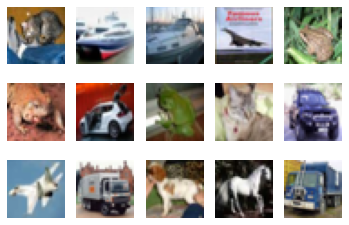

In [20]:
for i in range(0,15):
  plt.subplot(3,5,i+1)
  plt.axis('off')
  plt.imshow(array_to_img(x_test[i]))
plt.show()

In [21]:
x_train=x_train.astype('float32')/255.0
x_test =x_test.astype('float32')/255.0

In [31]:
"""x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test_mean = np.mean(x_test, axis=0)
x_test -= x_test_mean

print(y_train.shape, y_test.shape)"""

(50000, 1) (10000, 1)


In [22]:
print(x_train.shape, x_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [23]:
from keras.utils import np_utils

In [24]:
#one hot encoding
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)


In [35]:
#Crear una revisión de si existen ya pesos, cargarlos al modelo


In [25]:
#Realizar un Schedule para el learning rate y un checkpoint para salvar los pesos
#Existen diferente maneras de reducir el LR esta es una de ellas
# LR = initial_LR *drop **((1+epoch)/epochs_drop)
import math
def paso_deca(epoch):
  initial_LR = 0.1
  drop = 0.7
  epochs_drop = 7
  LRate = initial_LR * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return LRate


In [26]:
from keras.callbacks import LearningRateScheduler, EarlyStopping
LRate = LearningRateScheduler(paso_deca)

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# checkpoint
from keras.callbacks import ModelCheckpoint
filepath="/content/drive/MyDrive/Colab/mod_bas.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [29]:
early_stopping=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5,restore_best_weights=True)
#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
optimiz = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
mod_RN.compile(loss='categorical_crossentropy', optimizer=optimiz, metrics=['accuracy'])

In [30]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
batch_size=64 #64
epochs=30
history = mod_RN.fit(x_train,y_train, batch_size=batch_size*1,epochs=epochs,validation_data=(x_test,y_test), shuffle=True, verbose=1, callbacks=[checkpoint, tensorboard_callback,early_stopping])

Epoch 1/30
782/782 [==============================] - ETA: 0s - loss: 1.5094 - accuracy: 0.5026
Epoch 1: val_accuracy improved from -inf to 0.51550, saving model to /content/drive/MyDrive/Colab/mod_bas.hdf5
782/782 [==============================] - 450s 538ms/step - loss: 1.5094 - accuracy: 0.5026 - val_loss: 1.6362 - val_accuracy: 0.5155
Epoch 2/30
782/782 [==============================] - ETA: 0s - loss: 0.9871 - accuracy: 0.6763
Epoch 2: val_accuracy did not improve from 0.51550
782/782 [==============================] - 407s 521ms/step - loss: 0.9871 - accuracy: 0.6763 - val_loss: 1.8221 - val_accuracy: 0.4667
Epoch 3/30
782/782 [==============================] - ETA: 0s - loss: 0.7572 - accuracy: 0.7523
Epoch 3: val_accuracy improved from 0.51550 to 0.73220, saving model to /content/drive/MyDrive/Colab/mod_bas.hdf5
782/782 [==============================] - 411s 526ms/step - loss: 0.7572 - accuracy: 0.7523 - val_loss: 0.8090 - val_accuracy: 0.7322
Epoch 4/30
782/782 [===========

In [44]:
mod_RN.load_weights('/content/drive/MyDrive/Colab/mod_bas.hdf5')

In [47]:
batch_size=64 #64
epochs=15

In [48]:
history = mod_RN.fit(x_train,y_train, batch_size=batch_size*1,epochs=epochs,validation_data=(x_test,y_test), shuffle=True, verbose=1, callbacks=[checkpoint, tensorboard_callback,early_stopping], initial_epoch=11)

Epoch 12/15
782/782 [==============================] - 402s 513ms/step - loss: 0.5038 - accuracy: 0.8324 - val_loss: 0.6125 - val_accuracy: 0.8056
Epoch 13/15
782/782 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.9271
Epoch 13: val_accuracy improved from 0.80560 to 0.85460, saving model to /content/drive/MyDrive/Colab/mod_bas.hdf5
782/782 [==============================] - 401s 512ms/step - loss: 0.2318 - accuracy: 0.9271 - val_loss: 0.4882 - val_accuracy: 0.8546
Epoch 14/15
782/782 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 0.9494
Epoch 14: val_accuracy did not improve from 0.85460
782/782 [==============================] - 397s 507ms/step - loss: 0.1646 - accuracy: 0.9494 - val_loss: 0.5295 - val_accuracy: 0.8508
Epoch 15/15
782/782 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.9557
Epoch 15: val_accuracy did not improve from 0.85460


In [1]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [51]:
etiquetas = np.array(['aeroplano','automovil','pajaro','gato','ciervo','perro','rana','caballo','barco','camion'])
#%cd "/content/drive/MyDrive/ESPECIALZIACION/2Semestre/DEEP LEARNING AVANZADO-paniagua/squeez_grad_cbam/"
#!ls

In [52]:
plt.matshow(heatmap1)
plt.show

NameError: ignored

In [ ]:
preprocess_input = keras.applications.xception.preprocess_input

img_array = preprocess_input(get_img_array('rana1.jpg',size=(32,32)))
img_array = img_array.astype('float32')/255.0
mean = np.mean(img_array,axis=(0,1,2,3))
std = np.std(img_array,axis=(0,1,2,3))
img_array = (img_array - mean)/(std+1e-7)
preds1 = modelito.predict(img_array)

print(str(etiquetas[(np.argmax(preds1,axis=1))[0]]))

heatmap1 = make_gradcam_heatmap(img_array, modelito, 'activation_149')


save_and_display_gradcam('rana1.jpg',heatmap1,'rana.jpg')

In [ ]:
import matplotlib.cm as cm

In [ ]:
save_and_display_gradcam('pajaro2.jpg',heatmap1,'pajaro.jpg')

In [ ]:
mod_RN.load_weights('mod_bas.hdf5')

In [ ]:
history = mod_RN.fit(x_train,y_train, batch_size=batch_size*1,epochs=epochs,validation_data=(x_test,y_test), shuffle=True, verbose=1, callbacks=[checkpoint, early_stopping], initial_epoch=2)

In [ ]:
!nvidia-smi